In [3]:
import thirdparty
from thirdparty import *
from transformers import ViTImageProcessor, ViTForImageClassification

# 生成数据集

In [8]:
data_dir = '/root/autodl-tmp/data/'
data_name = 'cifar-100'
data_path = os.path.join(data_dir,data_name)
transform = transforms.Compose([transforms.PILToTensor()])#PILToTensor()不会进行标准化,ToTensor()会进行标准化
#加载训练数据集和测试数据集
train_dataset = datasets.cifar.CIFAR100(root=data_path, train=True,transform=transform, download=False)
test_dataset = datasets.cifar.CIFAR100(root=data_path, train=False,transform=transform, download=False)

In [9]:
# 观察训练数据集中的数据并查看数据量大小
index=10000
print(len(train_dataset))
print(len(test_dataset))
print(train_dataset[index])

50000
10000
(tensor([[[127, 125, 128,  ..., 137, 139, 141],
         [127, 127, 127,  ..., 137, 140, 140],
         [128, 125, 125,  ..., 139, 142, 141],
         ...,
         [126, 122, 119,  ...,  54,  29,  98],
         [130, 127, 128,  ...,  23,  72, 130],
         [129, 129, 130,  ...,  80, 122, 138]],

        [[140, 138, 140,  ..., 155, 155, 155],
         [141, 139, 139,  ..., 154, 156, 153],
         [144, 141, 140,  ..., 153, 156, 154],
         ...,
         [140, 136, 135,  ...,  40,  34, 113],
         [143, 139, 139,  ...,  26,  85, 143],
         [142, 139, 139,  ...,  90, 134, 147]],

        [[149, 150, 154,  ..., 163, 163, 164],
         [150, 152, 153,  ..., 162, 164, 162],
         [152, 152, 154,  ..., 162, 165, 163],
         ...,
         [149, 147, 146,  ...,  35,  31, 119],
         [152, 148, 148,  ...,  25,  87, 148],
         [151, 147, 147,  ...,  92, 138, 150]]], dtype=torch.uint8), 48)


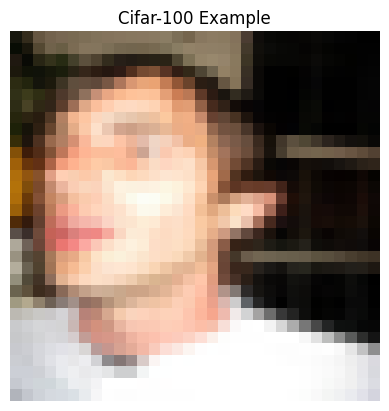

torch.Size([3, 32, 32])
46


In [10]:
#观察图像
index=25070
image,label=train_dataset[index]
image_show(image.numpy(),color_type="rgb",title="Cifar-100 Example")
print(image.size())
print(label)

# 导入预训练模型和预处理器

In [12]:
model_dir = '/root/autodl-tmp/model/'
model_name = 'vit-base'
model_path = os.path.join(model_dir,model_name)
processor = ViTImageProcessor.from_pretrained(model_path)
model = ViTForImageClassification.from_pretrained(model_path)

/root/miniconda3/lib/python3.8/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [16]:
# 观察模型结构
print(model)
for  name,p in model.named_parameters():
    #根据name自行指定想训练的层
    print(name)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [17]:
for name,p in model.named_parameters():
    #根据name自行指定想训练的层
    if('classifier' not in name):
        p.requires_grad=False
#分类层：改变模型结构，把类别调整成100
model.classifier=nn.Linear(in_features =768, out_features = 100)
model.to("cuda:0") 

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [18]:
# 统计模型参数参数量
def cal_paras(model):
    Total_params = 0
    Trainable_params = 0
    NonTrainable_params = 0
    for param in model.parameters():
        mulValue = np.prod(param.size())  # 使用numpy prod接口计算参数数组所有元素之积
        Total_params += mulValue  # 总参数量
        if param.requires_grad:
            Trainable_params += mulValue  # 可训练参数量
        else:
            NonTrainable_params += mulValue  # 非可训练参数量
    print(f'Total params: {Total_params}')
    print(f'Trainable params: {Trainable_params}')
    print(f'Non-trainable params: {NonTrainable_params}')

In [19]:
cal_paras(model)

Total params: 85875556
Trainable params: 76900
Non-trainable params: 85798656


In [20]:
#修改模型配置，分类，一次只有一个类
model.config.problem_type == "single_label_classification"
#改对应的配置，现在的类别是100
model.num_labels=100

# 训练

In [36]:
device = get_device()                 # 获取当前可用的设备
# 模型训练所需的超参数
config = {
    'n_epochs': 2,                # 训练轮数
    'batch_size':256,              # 批量大小
    'optimizer': 'Adam',             # 优化算法类型
    'optim_hparas': {                # 优化算法的超参数
        'lr': 0.0003,                 # 学习率
        'betas' : (0.9,0.999),           # 动量和梯度超参数
        'eps':1e-5,                  # 分母除零系数
        'weight_decay': 1e-8        # 权重衰减(可以看作是L2正则化前面的系数，真实系数是weight_decay/2)
    },
    'batch_show_step':10,          # 每一轮几个batch显示训练信息
    'epoch_show_step':1,           # 每几轮显示训练信息
    'save_model_dir':"./finetune-model/vit",
}
myseed = 42069  #设置随机种子
set_seed(myseed)

In [23]:
#制作训练要用的data_loader
batch_size = config["batch_size"]
train_set = DataLoader(train_dataset, batch_size,shuffle = True, drop_last=False,num_workers=0, pin_memory=True)

In [26]:
# 计算正确率需要用到的工具函数的集合
def get_data(batch_size,label_num,path):
    num=int(batch_size/len(label_num))
    data=[]
    for sub_data in label_num.values():
        if num<=len(sub_data):
            data.extend(random.sample(sub_data,num))
        else:
            data.extend(sub_data)
    images=[]
    labels=[]
    for p,label in data:
        try:  
            img_path="{}{}".format(path,p)
            img = Image.open(img_path)
            img2=np.array(img)
            img.close()
            if len(img2.shape)!=3:
                continue     
            images.append(img2)
            labels.append(label)
        except:
            continue
    return images,np.array(labels)
def no_contain(name,freeze_layer):
    for s in freeze_layer:
        if s in name:
            return False
    return True
def parser_data(path):
    with open(path,encoding="utf-8") as f:
        lines=[ eval(s.strip()) for s in f.readlines()]
    label_num={}
    for p,label in lines:
        if label not in label_num:
            label_num[label]=[]
        label_num[label].append([p,label])
    return label_num
def cal_right_rate(val_data):
    right=0
    images=val_data.data
    labels=val_data.targets
    data=random.sample([s for s in zip(images,labels)],500)
    images,labels=zip(*data)
    count=len(labels)
    for i,val_image in  enumerate(images):
        inputs = processor(images=val_image, return_tensors="pt").to("cuda:0") 
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class_idx = logits.argmax(-1).item()
        if predicted_class_idx==labels[i]:
            right+=1
    return right/count

In [38]:
def train(train_set, model, config, device):
    ''' Model training '''
    n_epochs = config['n_epochs']  # 得到训练轮数
    batch_show_step, epoch_show_step = config["batch_show_step"], config["epoch_show_step"] #得到epoch显示频率和batch显示频率
    criterion = nn.CrossEntropyLoss(reduction='mean') # 定义损失函数
    optimizer = getattr(torch.optim, config['optimizer'])(model.parameters(), **config['optim_hparas']) #定义优化器
    min_loss = 10000.
    epoch = 0
    while epoch < n_epochs:
        model.train()
        step = 0
        show_flag=False
        if((epoch + 1) % epoch_show_step == 1 or epoch_show_step == 1): show_flag=True
        for images, labels in train_set:  #迭代data_loader中的训练数据
            # 前向传播计算loss
            inputs = processor(images=images, return_tensors="pt").to(device)
            labels = labels.to(torch.int64) 
            loss= model(**inputs,return_dict=False,labels=labels)[0]
            # 反向传播更新参数
            optimizer.zero_grad()  # set gradient to zero
            loss.backward()  # compute gradient (backpropagation)
            optimizer.step()  # update model with optimizer
            step += 1
            if(show_flag):
                if (step % batch_show_step == 1 or batch_show_step==1):
                    print('epoch{:4d}|step = {:4d}, train_loss = {:.4f}'.format(epoch + 1, step,loss))
                    right_rate=cal_right_rate(test_dataset)
                    print (step,"准确率",right_rate)
        epoch += 1
        model.save_pretrained(config["save_model_dir"])
        torch.save(model, os.path.join(config["save_model_dir"],"pytorch_model.bin"))
        print("Save Model Succeed in epoch {}".format(epoch))
    print('Finished training after {} epochs'.format(epoch))
    return min_loss

In [39]:
loss = train(train_set,model,config,device)

Save Model Succeed in epoch 1
Save Model Succeed in epoch 2
Finished training after 2 epochs


# 测试

In [42]:
device = get_device()
processor = ViTImageProcessor.from_pretrained(model_path)
self_model_path = config["save_model_dir"]
#直接用pytorch的方式加载
model=torch.load(os.path.join(self_model_path,"pytorch_model.bin")).to(device) 
data=test_dataset.data
targets=test_dataset.targets
right=0
count=0
for i,image in enumerate(data):
    inputs = processor(images=image, return_tensors="pt").to(device) 
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()
    if predicted_class_idx==targets[i]:
        right+=1
    count+=1
    if(i%100==0):
        print ('index = {:5d}, total = {:5d}'.format(count,len(targets)))
print ("accuracy",right/count)

index =     1, total = 10000
index =   101, total = 10000
index =   201, total = 10000
index =   301, total = 10000
index =   401, total = 10000
index =   501, total = 10000
index =   601, total = 10000
index =   701, total = 10000
index =   801, total = 10000
index =   901, total = 10000
index =  1001, total = 10000
index =  1101, total = 10000
index =  1201, total = 10000
index =  1301, total = 10000
index =  1401, total = 10000
index =  1501, total = 10000
index =  1601, total = 10000
index =  1701, total = 10000
index =  1801, total = 10000
index =  1901, total = 10000
index =  2001, total = 10000
index =  2101, total = 10000
index =  2201, total = 10000
index =  2301, total = 10000
index =  2401, total = 10000
index =  2501, total = 10000
index =  2601, total = 10000
index =  2701, total = 10000
index =  2801, total = 10000
index =  2901, total = 10000
index =  3001, total = 10000
index =  3101, total = 10000
index =  3201, total = 10000
index =  3301, total = 10000
index =  3401,

# 利用模型输出分类

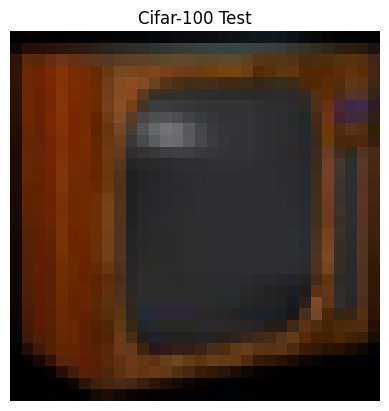

预测标签African grey, African gray, Psittacus erithacus,实际标签African grey, African gray, Psittacus erithacus


In [44]:
#图像处理器，把像素0~255 变成0~1，并且归一化图像大小
processor = ViTImageProcessor.from_pretrained(model_path)
#ViT模型  to("cuda:0")把模型放在GPU里面
model=torch.load(os.path.join(self_model_dir,"pytorch_model.bin")).to(device)
test_index=7050
image,class_idx=test_dataset[test_index]
image=np.array(image)
#图片的归一化，0~255 -> -1,1
inputs = processor(images=image, return_tensors="pt").to(device) 
# #预测
outputs = model(**inputs)
#各类的概率
logits = outputs.logits
#去概率最大的index
predicted_class_idx = logits.argmax(-1).item()
#概率最大的index对应的label名称
label_predict=model.config.id2label[predicted_class_idx]
label_real=model.config.id2label[class_idx]
image_show(image,title="Cifar-100 Test")
print ("预测标签{},实际标签{}".format(label_predict,label_real))

3347


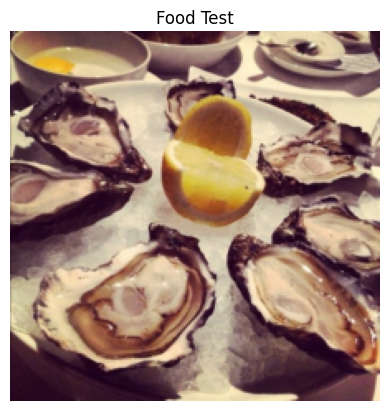

预测标签plate


In [55]:
device=get_device()
# 利用原始的vit-model进行分类，有1000个类别
show_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
])
test_dataset_food = SelfImageFolder(root_dir=os.path.join(data_dir,'food-11/testing/00'),transform=show_tfm)
print(len(test_dataset_food))#3347
index=1200
processor = ViTImageProcessor.from_pretrained(model_path)
model = ViTForImageClassification.from_pretrained(model_path).to(device)
image = test_dataset_food[index]
image = np.array(image)
#图片的归一化，0~255 -> -1,1
inputs = processor(images=image, return_tensors="pt").to("cuda:0") 
# 预测
outputs = model(**inputs)
#各类的概率
logits = outputs.logits
#去概率最大的index
predicted_class_idx = logits.argmax(-1).item()
#概率最大的index对应的label名称
label=model.config.id2label[predicted_class_idx]
image_show(image,title="Food Test")
print ("预测标签{}".format(label))